In [2]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
data = pd.read_csv("./유방암.CSV",engine="python")
data.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# 데이터 결측치 확인

In [3]:
# 결측치 없다.
data.isnull().sum(axis=0)

diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

# 데이터 타입 확인

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

In [5]:
# Checking if classes are unbalanced or balanced
data['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

# 'diagonosis'는 목표변수이다.
# 0은 악성이다. 1은 양성이다.
- '1' 은 Malignant으로 악성이다 -> 212/(212 + 357) = 0.37 
- '0' 은 Benign으로 양성이다 -> 357/(212+357) = 0.627

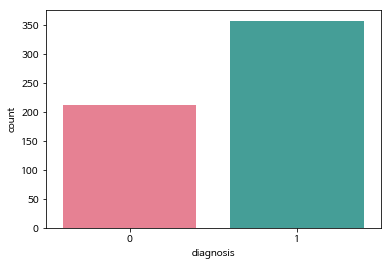

In [6]:
sns.countplot(data.diagnosis)
sns.countplot(data['diagnosis'],  palette = "husl")

# Correlation 비교
- 목표변수와 설명변수간의 상관계수 비교
- 상관관계를 확인해 크게 연관이 있는지 파악한다
- 상관관계는 인과관계를 내포하지 않아 상관관계가 큰 특징들이 목표변수에 무조건 변화를 일으키는 것은 아니다.
- **중요한 것은 음의 상관관계를 갖는 특성도 모델을 사용해 실제로 상관관계가 있는지 파악해야한다.**

In [7]:
# Check 설명변수와 목표변수간의 상관계수  
print('Features with the max correlation with diagnosis :')
# sort를 사용해 큰 순서로 상관계수 10개 뽑기
print(data.corr()['diagnosis'][1:-1].sort_values(ascending=False)[:10])
print('\n')
# sort를 사용해 작은 순서로 상관계수 10개 뽑기
print('Features with the least correlation with diagnosis :')
print(data.corr()['diagnosis'][:-1].sort_values()[:10]) 

Features with the max correlation with diagnosis :
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
mean symmetry             -0.330499
mean smoothness           -0.358560
concave points error      -0.408042
Name: diagnosis, dtype: float64


Features with the least correlation with diagnosis :
worst concave points   -0.793566
worst perimeter        -0.782914
mean concave points    -0.776614
worst radius           -0.776454
mean perimeter         -0.742636
worst area             -0.733825
mean radius            -0.730029
mean area              -0.708984
mean concavity         -0.696360
worst concavity        -0.659610
Name: diagnosis, dtype: float64


# No insights
- 다른 특징들의 대부분에 차이가 있음을 알 수 있다.
- **다양한 특징의 범위가 다르게 보이기 때문에 normalize/scale이 필요하다**
- **또한 X변수에 목표변수도 drop해야 한다**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0E5CF5668>,
      dtype=object)

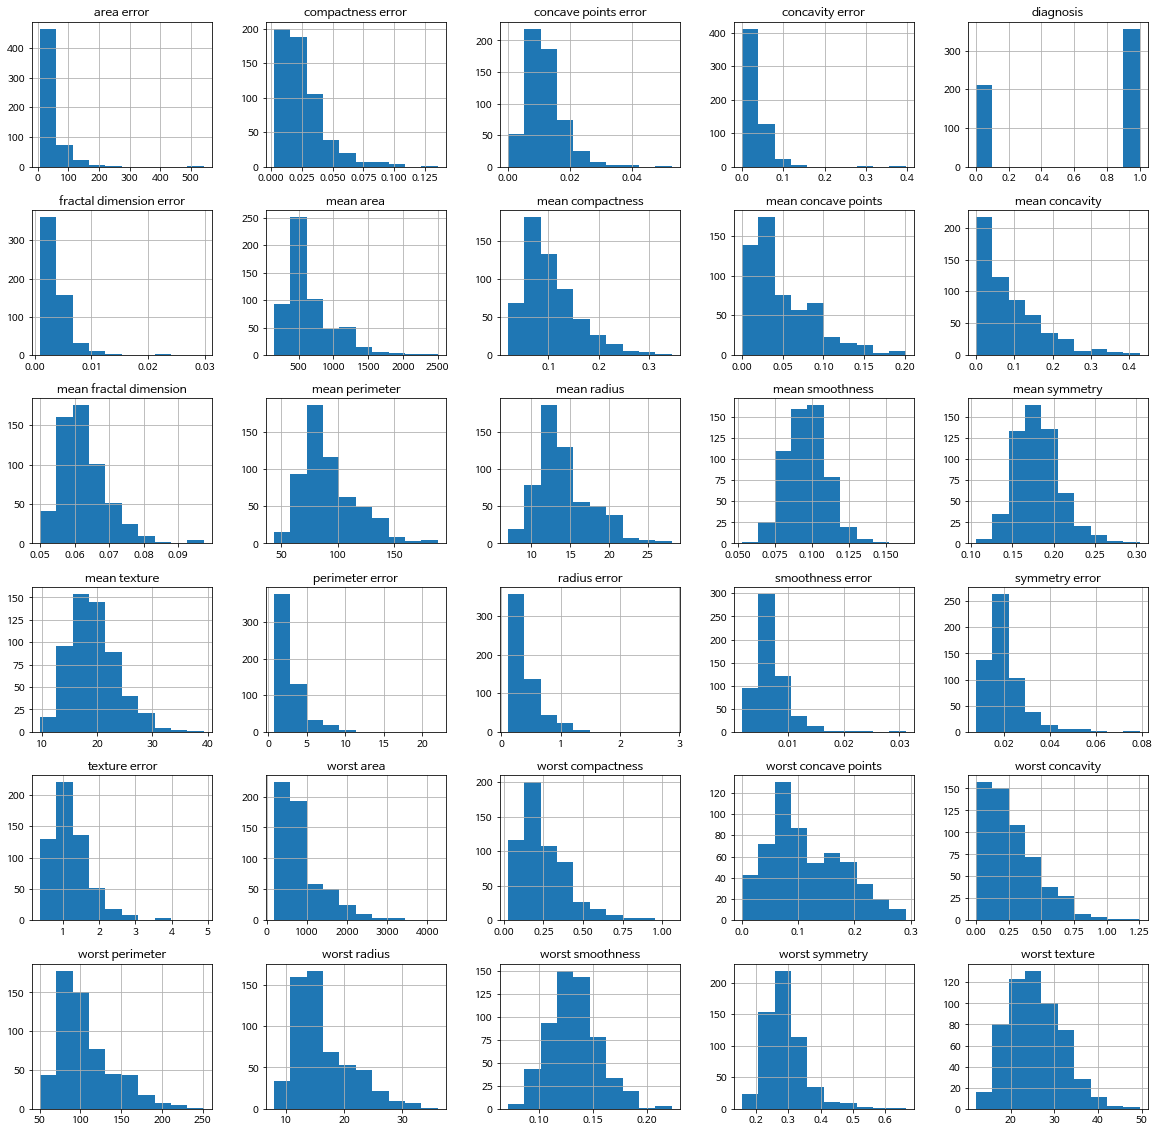

In [21]:
X = data.iloc[:,0:-1]
X.hist(figsize = (20,20))

# 데이터 스케일
- **1. 모든 분포가 왼쪽으로 치우쳐 있기 때문에 로그 변환을 적용해 분포를 보다 정상으로 만들고 왼쪽 꼬리를 중앙으로 sacle한다**

- **2. 전체 데이터를 (0,1)사이의 MinMaxScaler과 평균 0 표준 편차 1 만들어 값을 변화시킨다.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0E5713E48>,
      dtype=object)

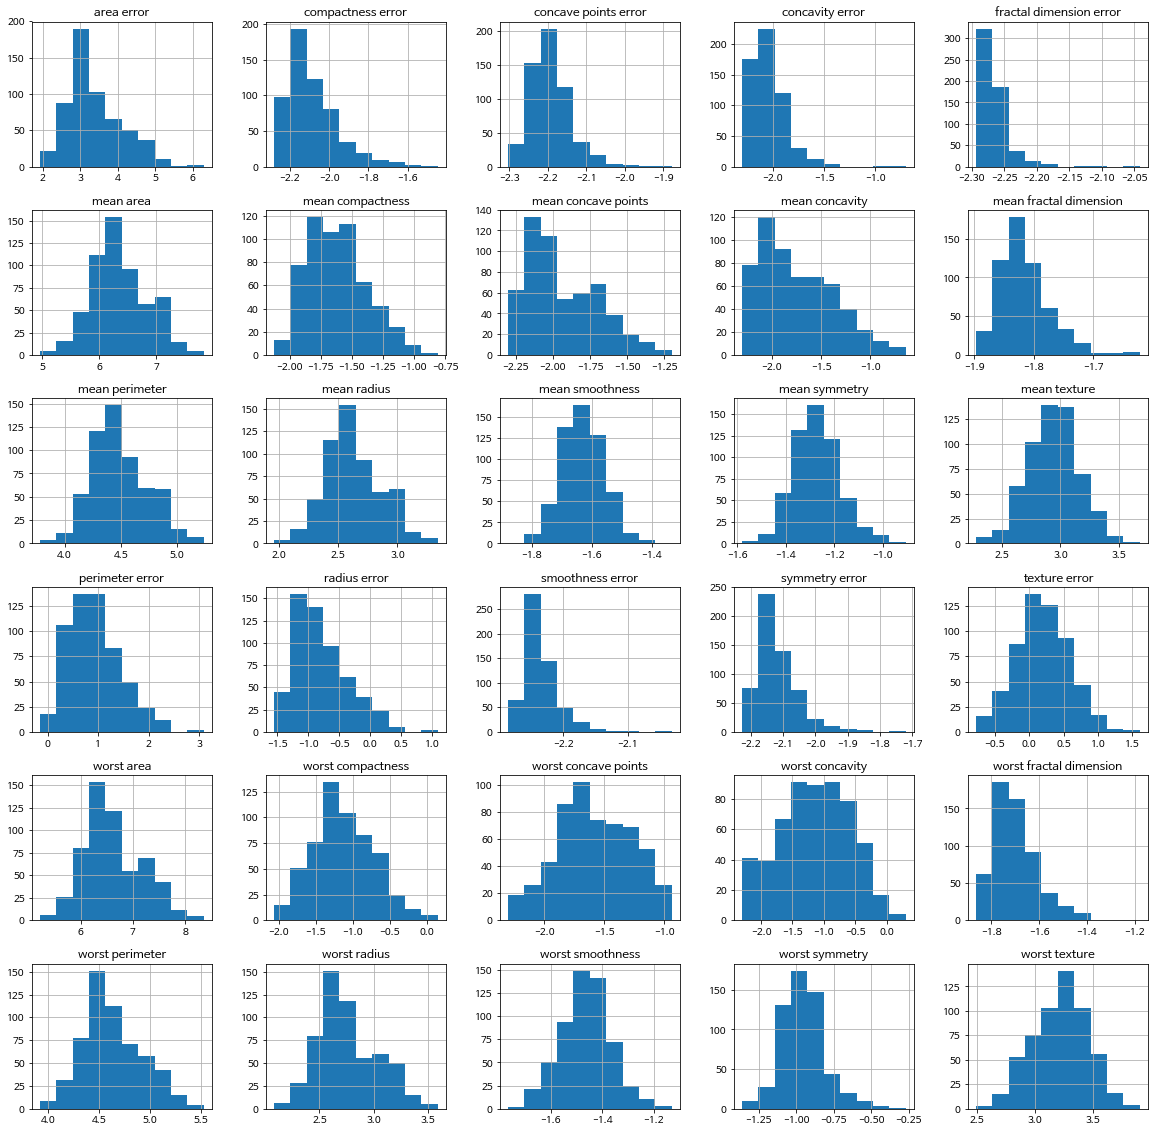

In [10]:
data_x = data.drop("diagnosis",axis=1)
data_y = data["diagnosis"]

X_log = data_x.apply(lambda x: np.log(x + 0.1))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)
X_log.hist(figsize = (20,20))

In [11]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(data.shape[0]) < 0.7
data_train = data[msk]
data_test = data[~msk]

# train/test 데이터의 목표변수/설명변수 지정
data_train_y = data_train["diagnosis"]
data_train_x = data_train.drop("diagnosis", axis=1, inplace=False)
data_test_y = data_test["diagnosis"]
data_test_x = data_test.drop("diagnosis", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(data_train_x.shape))
print("train data Y size: {}".format(data_train_y.shape))
print("test data X size: {}".format(data_test_x.shape))
print("test data Y size: {}".format(data_test_y.shape))
# train data: 385, test data: 184

train data X size: (385, 30)
train data Y size: (385,)
test data X size: (184, 30)
test data Y size: (184,)


# 의사결정나무 (Decision Tree)

In [12]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(data_train_x, data_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(tree_uncustomized.score(data_train_x,
                                                                      data_train_y)))
print("Accuracy on training set:{:3f}".format(tree_uncustomized.score(data_test_x,
                                                                      data_test_y)))


Accuracy on training set:1.000
Accuracy on training set:0.934783


# tree model 옵션 확인

In [13]:
tree_uncustomized.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')>

# GridSearchCV 사용
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~50까지 잡는다. (tree - 최대 깊이)**
- **num_leafs는 Tree의 leaf**

In [14]:
depths = np.arange(1,51)
num_leafs = [1,5,10,20,50,100]
para_criterion = ["gini", "entropy"]
param_grid = [{'criterion' : para_criterion, 'max_depth': depths, 'min_samples_leaf':num_leafs}]

tree_GS = DecisionTreeClassifier(random_state=1234)
gs = GridSearchCV(estimator=tree_GS, param_grid=param_grid,cv=10)
gs = gs.fit(data_train_x,data_train_y)
gs

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), 'min_samples_leaf': [1, 5, 10, 20, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# GridSearch 출력
- **GridSearch를 했을 때 가장좋은 test accuracy중 가장 좋은 score를 출력**
- **그 때 조합들의 parameter를 출력했다.**

In [15]:
print(gs.best_score_)
print(gs.best_params_)

0.935064935064935
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}


In [16]:
my_model = gs.best_estimator_
my_model.fit(data_train_x,data_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

# GridSearch의 Parameter로 DecisionTree 출력

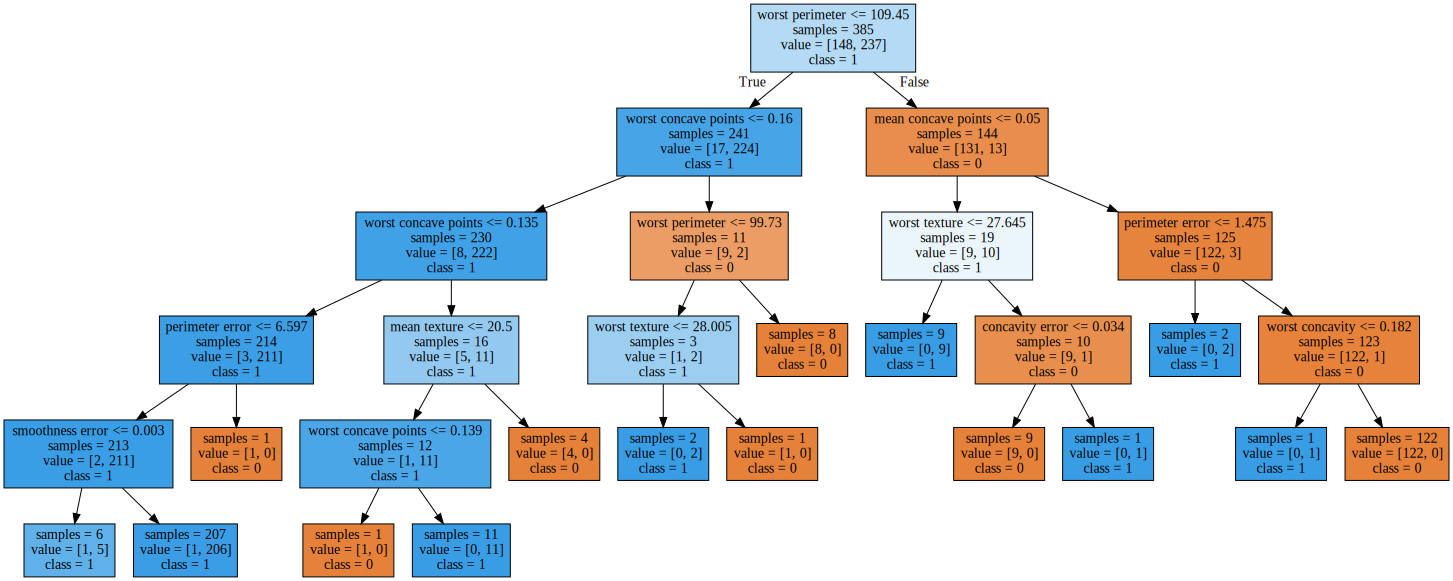

In [17]:
tree = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_leaf=1, random_state=1234)
tree.fit(data_train_x, data_train_y)
export_graphviz(tree, out_file="tree.dot", class_names=["0","1"],
               feature_names=data_train_x.columns, impurity=False, filled=True)

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [18]:
# 최종 모델
rf_model = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_leaf=1,random_state=1234)
rf_model.fit(data_train_x,data_train_y)
# rf_model.featrue_importance_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = data_train_x.columns
ds_feature_importance["importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values(by="importance",ascending=False)


,feature,importance
22,worst perimeter,0.721891
27,worst concave points,0.097288
21,worst texture,0.050444
7,mean concave points,0.046613
12,perimeter error,0.032627
1,mean texture,0.028236
26,worst concavity,0.011110
16,concavity error,0.010081
14,smoothness error,0.001711
20,worst radius,0.000000


# 설명변수 중요도
- **worst perimeter (0.721891)와 worst concave points(0.097288)가 중요하다.**
- **다음으로 worst texture(0.050444)와 mean concave points(0.046613)의 변수를 살펴 보면 된다**

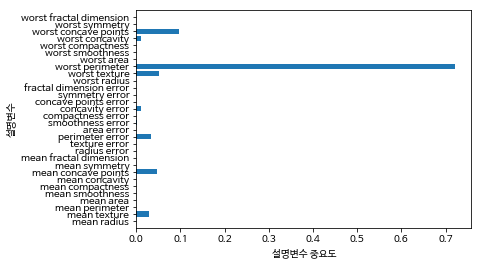

In [19]:
def plot_feature_importances(model):
    n_feature = data_train_x.shape[1]
    plt.barh(range(n_feature),model.feature_importances_,align="center")
    plt.yticks(np.arange(n_feature), data_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_feature)
# 설명변수 중요도 그리는 함수 실행
plot_feature_importances(rf_model)
    